# Exercise 2 - Convolutional Neural Nets (CNN's)

In the last notebook you built a feedforward net, and found that it could recognise handwritten digits remarkably well. However, when trying to recognise diverse objects on images we ran into performance issues. In this notebook you will learn to implement a simple CNN in Keras and apply it to CIFAR-10.

The set-up of this notebook is similar to the previous. You are expected to complete certain parts of the code to be able to run it.

## 1 - Packages

First we begin by importing the required packages

In [1]:
#download required datasets for this notebook (might take a bit, be patient!)
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if os.path.isfile(file):
        os.remove(file)
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")
        
def unzip(file):
    with ZipFile(file) as f:
        f.extractall()
    print('unzipped file: %s\n' %file)

try:
    download('http://www.paulvangent.com/files/DL_Course/utils_day1.py', 'utils_day1.py')
except:
    download('https://onedrive.live.com/download?cid=39383A5AFCD95065&resid=39383A5AFCD95065%21754588&authkey=ANqFqQOFr4Iqy1A', 'utils_day1.py')

import numpy as np #import numpy package
import matplotlib.pyplot as plt #import plotting library
import utils_day1 as utils #import helper functions

#import required keras modules
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, Conv1D, MaxPooling2D, RepeatVector

Download file... utils_day1.py ...
File downloaded


Using TensorFlow backend.


## 2 - Dataset

We load the CIFAR-10 dataset again. 

**Note** that we do not need to flatten the images. Remember from the lecture that a convolution can operate on two dimensional image data.

In [0]:
from keras.datasets import cifar10

(X_train, Y_train), (X_val, Y_val) = cifar10.load_data()

We do, however, still need to apply one-hot encoding and normalise the images. In the last notebook you did this with [numpy.eye()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html).

Your task here is to use a built-in keras function, called [to_categorical](https://keras.io/utils/#to_categorical). Complete the code below to convert Y_train and Y_val to one-hot encoding using this function. Look at the link for a hint, and note that the dataset has **10 classes**.

In [0]:
from keras.utils import to_categorical

#Apply one-hot encoding
##Start your code here (approx. 2 lines)
Y_train = to_categorical(Y_train, num_classes=10)
Y_val = to_categorical(Y_val, num_classes=10)
##End of your code

#Normalise the images
##Start your code here (approx. 2 lines)
X_train = X_train / 255.
X_val = X_val / 255.
#End your code here

print('Shape of first training label: ' + str(Y_train[0].shape))
print('Shape of last validation label: ' + str(Y_val[-1].shape))
print('mean pixel value of first training example: ' + str(np.mean(X_train[0])))
print('mean pixel value of last validation example: ' + str(np.mean(X_val[-1])))

Shape of first training label: (10,)
Shape of last validation label: (10,)
mean pixel value of first training example: 0.40567555147058826
mean pixel value of last validation example: 0.42338388480392153


***

**Expected output:**

Shape of first training label: (10,)  
Shape of last validation label: (10,)  
mean pixel value of first training example: 0.405675551471  
mean pixel value of last validation example: 0.423383884804

## 3 - Defining a CNN in Keras

Implementing a CNN in Keras is very similar to implementing a feedforward network, with the exception that we use different layer types. For an overview of all available convolutional layers, see [this link](https://keras.io/layers/convolutional/).

[**Please take a look here for some additional reading material regarding Convolutions**](https://arxiv.org/pdf/1603.07285v1.pdf)


***

Your task is to implement a CNN with the following structure:

- Convolutional 2D input layer. Use the following parameters:
    * 32 filters
    * kernel size of (3, 3)
    * input shape equal to input_shape
    * relu activation
- Max pooling 2D layer. Use a poolsize of (2, 2)
- Regularisation layer. Use a dropout rate of 20%
- Flattening layer 
- Dense layer, use 256 units and relu activation.
- Output layer with 10 classes and softmax activation.


Can you explain **why** we need to add a flatten layer between the CNN part of the network and the Dense layers?

In [0]:
def baseline_model(input_shape=(32,32,3), classes=10):
    model = Sequential()
    ##Add your code here (approx. 6 lines)
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     padding='same',
                     strides=(2,2),
                     input_shape=input_shape,
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    ##End of your code
    
    
    return model

We then initialise the model:

In [0]:
model = baseline_model()

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)      

***
**Expected Output:**

![model summary](http://www.paulvangent.com/files/DL_Course/day1_images/cnn_network.jpg)

**Compare this to the FeedForward network summary from the previous notebook (we've recreated the image below).**

![FFN model](http://www.paulvangent.com/files/DL_Course/day1_images/feedforwardmodel.jpg)

**Can you explain why the CNN has fewer parameters, yet gets much better results?**


***
## 4 - Loss Functions and Optimization

This section will detail the loss function and optimization of your network.

### 4.1 Loss Function
Remember from the lecture this morning, that in order to optimize the model we need to express its accuracy. Expressing the mistakes the model makes is done with a loss function, which quantifies the distance between the expected output and the predicted output. An easy example to understand is that of the logistic loss function:

![logloss](http://www.paulvangent.com/files/DL_Course/day1_images/logloss.jpg)

**Note:** **y** is often used for the true label, and y-hat (**ŷ**) for the predicted value.

To see what it does, note that the function has two sides (left and right of ‘+’). The function expresses the similarity of prediction and true value. It 'punishes' larger deviations more severly. When the prediction and true value are very similar the loss is low, when they differ a lot the loss is high. To think visually, consider the plot below:

![loglossgraph](http://www.paulvangent.com/files/DL_Course/day1_images/log_loss_graph.png)

Still not 100% clear on what happens? Consider two opposite cases:

***
<center>**y=1**  
The right side of the formula falls off because (1 – y) = 0, so that implies that for -log(ŷ) you want ŷ to be 1 (or close to 1), since log(1)=0.  </center>
  
<center>**y=0**  
Now the left side of the formula falls off (0 log (ŷ) = ..). Now we need log(1 – ŷ) to be close to 0 to mach y, which happens if ŷ=0.</center>

***

Logloss is only applicable when there are two possible outcomes (binary classification). In the exercise below we will be using **categorical crossentropy**, which is very similar to logloss, except that it can handle more than two possible outcomes.

[**You can see the mathematical definition of the categorical crossentropy here**](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/)

***

### 4.2 - Optimizer
The loss function allows us to quantify the mistakes made by model, which makes it possible to reduce them. Remember from the lectures that the optimizer will try to gradually step towards a point of minimum loss. Consider a hypothetical, one-dimensional loss function to illustrate:

![onedimloss](http://www.paulvangent.com/files/DL_Course/day1_images/gradientdescent0.jpg)

Obviously we want to minimise **C(W)**, because a low loss means the difference between predictions and actual values is small as we discussed in 4.1. In the context of the figure: the optimizer decides which way is 'downhill', and updates the model's weights so that the loss decreases:

![stepping to minimum](http://www.paulvangent.com/files/DL_Course/day1_images/gradientdescent2.jpg)

An excellent overview of the different optimizers [can be found here](http://ruder.io/optimizing-gradient-descent/).

In this notebook we use the Adam optimiser. In many cases Adam will converge quickly, which is useful here because many of you are running the code without a GPU.

***
**Exercise:**  
We still need to compile the model, meaning we will be asking Keras to transform our model instructions into machine-readable code. Compile the model with a 'categorical_crossentropy' loss and an 'adam' optimizer. 

Hint: refer to how we did this in the previous notebook if you're unsure how to do this.

In [0]:
##Add your code here (approx. 1 line)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
##End of your code

Your task is now to fit the model for 10 epochs with a batch size of 256. Remember to also set the validation data sets!

Hint: Refer to the previous notebook on how to do so if you are unsure.

In [0]:
##Add your code here
history = model.fit(X_train, Y_train,
                   validation_data = (X_val, Y_val),
                   epochs=10,
                   batch_size=256)
##End of your code.

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 118us/step - loss: 1.7256 - acc: 0.3911 - val_loss: 1.4585 - val_acc: 0.4896
Epoch 2/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.3857 - acc: 0.5112 - val_loss: 1.3173 - val_acc: 0.5314
Epoch 3/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.2755 - acc: 0.5533 - val_loss: 1.2169 - val_acc: 0.5732
Epoch 4/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.2155 - acc: 0.5720 - val_loss: 1.1890 - val_acc: 0.5833
Epoch 5/10
50000/50000 [==============================] - 2s 44us/step - loss: 1.1591 - acc: 0.5943 - val_loss: 1.1354 - val_acc: 0.6033
Epoch 6/10
50000/50000 [==============================] - 2s 44us/step - loss: 1.1269 - acc: 0.6064 - val_loss: 1.1067 - val_acc: 0.6151
Epoch 7/10
50000/50000 [==============================] - 2s 44us/step - loss: 


***
Note that we added 'history = ' before the model.fit command. Remember that by default, a Keras model will return a history object containing information on the training epochs. Run the cell below to plot the results of your training phase

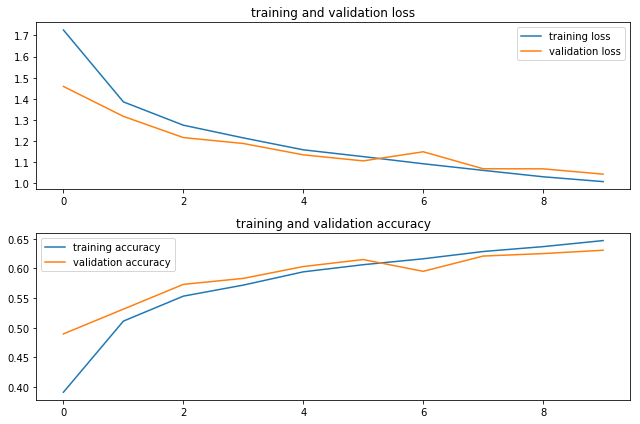

In [0]:
utils.plotter(history)

Take a look at the plot. **What do you think? Is the model overfitting or not? Why (not)?** 

Based on this graph, would you try to run the model for more epochs or not?

***

## 5 - Expanding the CNN (optional)

In this last section of the notebook we will be expanding the CNN network. A bigger network will have more capacity to fit the variance in the dataset.

This section is optional because without a discrete GPU (which most of your laptops will not have), training will take long. Once it works you can turn on the model at night and let the laptop run for a while.

We have copied an example of the baseline model below. Your task is to add two Conv2D layers to it.

- Convolutional 2D input layer. Use the following parameters:
    * 64 filters
    * filtersize of (5, 5)
    * use 'same' padding
    * input shape of (32, 32, 3)
    * relu activation
- Max Pooling layer with a poolsize of 2
- Convolutional 2D input layer. Use the following parameters:
    * 128 filters
    * filtersize of (3, 3)
    * use 'same' padding
    * input shape of (32, 32, 3)
    * relu activation

In [0]:
def expanded_model(input_shape=(32, 32, 3), classes=10):
    ##Add your code here (approx. 5 lines)
    model = Sequential()
    model.add(Conv2D(filters=64,
                     kernel_size=(5, 5),
                     padding='same',
                     input_shape=input_shape,
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    ##End of your code
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    ##End of your code
    
    
    return model

In [0]:
model = expanded_model()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Your task here is to again fit the model. Use the same setting as earlier (10 epochs, batchsize 256).

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 6s 111us/step - loss: 1.6032 - acc: 0.4148 - val_loss: 1.3260 - val_acc: 0.5199
Epoch 2/10
50000/50000 [==============================] - 5s 94us/step - loss: 1.2160 - acc: 0.5664 - val_loss: 1.1699 - val_acc: 0.5846
Epoch 3/10
50000/50000 [==============================] - 5s 93us/step - loss: 1.0504 - acc: 0.6307 - val_loss: 1.0185 - val_acc: 0.6376
Epoch 4/10
50000/50000 [==============================] - 5s 94us/step - loss: 0.9476 - acc: 0.6678 - val_loss: 0.9086 - val_acc: 0.6854
Epoch 5/10
50000/50000 [==============================] - 5s 94us/step - loss: 0.8616 - acc: 0.6965 - val_loss: 0.8899 - val_acc: 0.6891
Epoch 6/10
50000/50000 [==============================] - 5s 96us/step - loss: 0.7927 - acc: 0.7222 - val_loss: 0.8478 - val_acc: 0.7027
Epoch 7/10
50000/50000 [==============================] - 5s 95us/step - loss: 0.7281 - acc: 0.7440 - val_loss: 0.8124 - val_ac

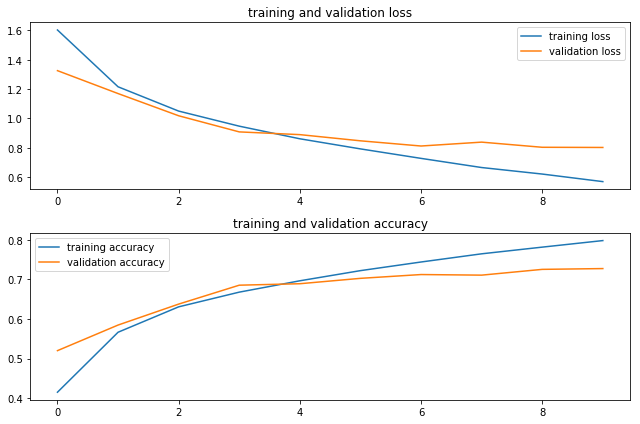

In [0]:
##Add your code here
history = model.fit(X_train, Y_train,
                   validation_data = (X_val, Y_val),
                   epochs=10,
                   batch_size=256)
##End of your code.

utils.plotter(history) #plot results

So, how did the model perform? Our iteration reached ~73% in the end. **Would you try extra epochs? Why (not)?**

You might wonder, how does the model work on the MNIST dataset from the first notebook? It would take too much time to let the model converge on your laptop in the few hours we have today. We ran it for 25 epochs on a gpu though, and it reached **98.94%** validation accuracy. That's pretty good!

## 6 - Wrapping up

You've reached the end of the second notebook. Hoo-ray, you're now a certified Deep Learner! You might now want to go online, get some bigger datasets, and try larger networks for yourself. You might also want to try applying what you learned to your own data.

Be warned that beyond this point a GPU becomes mandatory. Even a low-budget one can speed up training dramatically, making the difference between fitting a model for a night or over a month.

![GPU MANDATORY](http://www.paulvangent.com/files/DL_Course/day1_images/needgpu.jpg)

***

Tomorrow there will be more exercises!